# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p6t4r735 because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os

import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [5]:
target_idx = label_annot['wtCas9_cleave_rate_log']

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.1-ga


In [7]:
def get_uniform_ms(n_states, st_win_size=7):
    """an evenly-spaced model space, separating 20nt for given n_states
    """
    st_win = np.arange(st_win_size) - st_win_size//2
    anchors = {s:i for s,i in enumerate(np.arange(0, 23, np.ceil(23/n_states), dtype='int'))}
    ls = []
    default_ks = lambda: pmbga.Categorical(choices=[1,3,5], prior_cnt=1)
    default_d = lambda: pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1)
    default_st = lambda a: pmbga.Categorical(choices=np.clip(a+st_win, 0, 23), prior_cnt=1)
    for s in range(0, n_states-1):
        ls.append([dict(Layer_type='conv1d', filters=1, SOURCE=str(s), TARGET=str(s+1), EDGE=1,
            kernel_size=default_ks(),
            RANGE_ST=default_st(anchors[s]),
            RANGE_D=default_d()
            )])
        ls.append([dict(Layer_type='conv1d', filters=1, SOURCE=str(s+1), TARGET=str(s), EDGE=1,
            kernel_size=default_ks(),
            RANGE_ST=default_st(anchors[s]),
            RANGE_D=default_d()
            )])
    # last rate: cleavage, irreversible
    ls.append([dict(Layer_type='conv1d', filters=1, SOURCE=str(s+1), TARGET='0', EDGE=1,
            kernel_size=pmbga.Categorical(choices=[1,2,3,4,5,6], prior_cnt=[1]*6),
            RANGE_ST=pmbga.Categorical(choices=np.arange(0, 20), prior_cnt=[1]*20),
            RANGE_D=default_d(),
            CONTRIB=1
            )])
    return ModelSpace.from_dict(ls)



#kinn_model_space = get_uniform_ms(n_states=4, st_win_size=7)

#print(kinn_model_space)

In [8]:
default_ks = lambda: pmbga.Categorical(choices=[1,3,5], prior_cnt=1)

kinn_model_space = ModelSpace.from_dict([
    # k_01, sol -> open R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='0', TARGET='1', 
          kernel_size=1,
          EDGE=1,
          RANGE_ST=0,
          RANGE_D=3, 
     )],
    # k_10, open R-loop -> sol
    [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='0', 
          kernel_size=1,
          EDGE=1,
          RANGE_ST=0,
          RANGE_D=3,          
     )],
    # k_12, open R-loop -> intermediate R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='1', TARGET='2', 
          kernel_size=default_ks(), 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[3,4,5,6,7,8,9,10], prior_cnt=1),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1), 
     )],
    # k_21, intermediate R-loop -> open R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='1', 
          kernel_size=default_ks(), 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[3,4,5,6,7,8,9,10], prior_cnt=1),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),             
     )],
    # k_23, intermediate R-loop -> closed R-loop
    [dict(Layer_type='conv1d', filters=1, SOURCE='2', TARGET='3', 
          kernel_size=default_ks(), 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=[7,8,9,10,11,12,13,14,15,16,17,18], prior_cnt=1),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),     
     )],
    # k_32
    [dict(Layer_type='conv1d', filters=1, SOURCE='3', TARGET='2', 
          kernel_size=default_ks(),
          EDGE=1,        
          RANGE_ST=pmbga.Categorical(choices=[7,8,9,10,11,12,13,14,15,16,17,18], prior_cnt=1),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1),          
     )],
    # k_30
    [dict(Layer_type='conv1d', filters=1, SOURCE='3', TARGET='0', 
          kernel_size=pmbga.Categorical(choices=[1,3,5,7], prior_cnt=1), 
          EDGE=1,
          RANGE_ST=pmbga.Categorical(choices=np.arange(0,23), prior_cnt=1),
          RANGE_D=pmbga.ZeroTruncatedNegativeBinomial(alpha=5, beta=1), 
          CONTRIB=1
     )],
])

print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [9]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,  # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
        )

## Components before they are implemented in AMBER

In [10]:
## NEEDS RE-WORK
# poorman's manager get reward
def get_reward_pipeline(model_arcs):
    from warnings import simplefilter
    simplefilter(action='ignore', category=DeprecationWarning)
    tf.reset_default_graph()
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    model_params = modelSpace_to_modelParams(model_arcs)
    with train_graph.as_default(), train_sess.as_default():
        kinn_test = KineticModel(model_params)
        mb = KineticNeuralNetworkBuilder(kinn=kinn_test, session=train_sess, n_channels=13)
        # train and test
        mb.build(optimizer='adam', plot=False, output_act=False)
        model = mb.model
        x_train_b = mb.blockify_seq_ohe(x_train)
        x_test_b = mb.blockify_seq_ohe(x_test)
        checkpointer = ModelCheckpoint(
            filepath="./outputs/bestmodel.h5", mode='min', verbose=0, save_best_only=True,
            save_weights_only=True)
        earlystopper = EarlyStopping(
            monitor="val_loss",
            mode='min',
            patience=5,
            verbose=0)

        model.fit(x_train_b, y_train[:,target_idx],
                  batch_size=768,
                  validation_split=0.1,
                  callbacks=[checkpointer, earlystopper],
                  epochs=75, verbose=0)
        y_hat = model.predict(x_test_b).flatten()
        test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]
    tf.keras.backend.clear_session()
    del train_graph, train_sess
    gc.collect()
    return test_pcc

## A fancy For-Loop that does the work for `amber.architect.trainEnv`

In [11]:
# trainEnv parameters
samps_per_gen = 10   # how many arcs to sample in each generation; important
max_gen = 1000
epsilon = 0.05
patience = 200
n_warmup_gen = -1

In [12]:
def compute_eps(model_space_probs, old_probs=None):
    delta = []
    samp_probs = {}
    for p in model_space_probs:
        #print(p)
        samp_probs[p] = model_space_probs[p].sample(size=10000)
        n = np.percentile(samp_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
        if old_probs is None:
            delta.append( np.mean(np.abs(n)) )
        else:
            o = np.percentile(old_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
            delta.append( np.mean(np.abs(o - n)) )
    return np.mean(delta), samp_probs 

# get prior probas
_, old_probs = compute_eps(controller.model_space_probs)

In [13]:
hist = []
pc_cnt = 0
best_indv = 0
stat_df = pd.DataFrame(columns=['Generation', 'GenAvg', 'Best', 'PostVar'])
for generation in range(max_gen):
    try:
        start = time.time()
        has_impr = False
        #for _ in tqdm(range(samps_per_gen), total=samps_per_gen, position=0, leave=True):
        for _ in range(samps_per_gen):
            # get arc
            arc, _ = controller.get_action()
            # get reward
            try:
                test_pcc = get_reward_pipeline(arc)
            #except ValueError:
            #    test_pcc = 0
            except Exception as e:
                raise e
            rate_df = None
            # update best, or increase patience counter
            if test_pcc > best_indv:
                best_indv = test_pcc
                has_impr = True
                shutil.move(os.path.join("outputs", "bestmodel.h5"), os.path.join("outputs", "AmberSearchBestModel.h5"))
            # store
            _ = controller.store(action=arc, reward=test_pcc)
            hist.append({'gen': generation, 'arc':arc, 'test_pcc': test_pcc, 'rate_df': rate_df})
        end = time.time()
        if generation < n_warmup_gen:
            print(f"Gen {generation} < {n_warmup_gen} warmup.. skipped - Time %.2f" % (end-start), flush=True)
            continue
        _ = controller.train(episode=generation, working_dir=".")
        delta, old_probs = compute_eps(controller.model_space_probs, old_probs)
        post_vars = [np.var(x.sample(size=100)) for _, x in controller.model_space_probs.items()]
        stat_df = stat_df.append({
            'Generation': generation,
            'GenAvg': controller.buffer.r_bias,
            'Best': best_indv,
            'PostVar': np.mean(post_vars)
        }, ignore_index=True)
        print("[%s] Gen %i - Mean fitness %.3f - Best %.4f - PostVar %.3f - Eps %.3f - Time %.2f" % (
            datetime.now().strftime("%H:%M:%S"),
            generation, 
            controller.buffer.r_bias, 
            best_indv, 
            np.mean(post_vars),
            delta,
            end-start), flush=True)
        #if delta < epsilon:
        #    print("stop due to convergence criteria")
        #    break
        pc_cnt = 0 if has_impr else pc_cnt+1
        if pc_cnt >= patience:
            print("early-stop due to max patience w/o improvement")
            break
    except KeyboardInterrupt:
        print("user interrupted")
        break

datapoints:  6 / total:  10
[01:06:09] Gen 0 - Mean fitness 0.575 - Best 0.6926 - PostVar 8.264 - Eps 0.763 - Time 118.42
datapoints:  12 / total:  20
[01:08:10] Gen 1 - Mean fitness 0.603 - Best 0.7042 - PostVar 7.961 - Eps 0.510 - Time 117.37
datapoints:  23 / total:  30
[01:10:08] Gen 2 - Mean fitness 0.587 - Best 0.7044 - PostVar 7.953 - Eps 0.276 - Time 115.48
datapoints:  22 / total:  40
[01:12:06] Gen 3 - Mean fitness 0.641 - Best 0.7044 - PostVar 8.663 - Eps 0.515 - Time 114.63
datapoints:  33 / total:  50
[01:14:05] Gen 4 - Mean fitness 0.624 - Best 0.7044 - PostVar 8.275 - Eps 0.204 - Time 115.21
datapoints:  37 / total:  60
[01:16:02] Gen 5 - Mean fitness 0.632 - Best 0.7044 - PostVar 7.851 - Eps 0.104 - Time 113.90
datapoints:  43 / total:  70
[01:18:00] Gen 6 - Mean fitness 0.632 - Best 0.7072 - PostVar 8.335 - Eps 0.081 - Time 114.80
datapoints:  41 / total:  80
[01:20:12] Gen 7 - Mean fitness 0.647 - Best 0.7100 - PostVar 8.726 - Eps 0.222 - Time 128.72
datapoints:  66 /

datapoints:  213 / total:  500
[03:20:34] Gen 66 - Mean fitness 0.684 - Best 0.7629 - PostVar 6.920 - Eps 0.111 - Time 118.09
datapoints:  266 / total:  500
[03:22:35] Gen 67 - Mean fitness 0.678 - Best 0.7629 - PostVar 7.049 - Eps 0.119 - Time 117.53
datapoints:  102 / total:  500
[03:24:34] Gen 68 - Mean fitness 0.701 - Best 0.7629 - PostVar 7.678 - Eps 0.363 - Time 116.04
datapoints:  367 / total:  500
[03:26:40] Gen 69 - Mean fitness 0.656 - Best 0.7629 - PostVar 6.573 - Eps 0.452 - Time 121.95
datapoints:  328 / total:  500
[03:28:39] Gen 70 - Mean fitness 0.666 - Best 0.7629 - PostVar 7.075 - Eps 0.067 - Time 115.71
datapoints:  293 / total:  500
[03:30:42] Gen 71 - Mean fitness 0.675 - Best 0.7629 - PostVar 7.152 - Eps 0.067 - Time 119.87
datapoints:  208 / total:  500
[03:32:45] Gen 72 - Mean fitness 0.687 - Best 0.7629 - PostVar 6.918 - Eps 0.170 - Time 120.05
datapoints:  105 / total:  500
[03:34:55] Gen 73 - Mean fitness 0.702 - Best 0.7629 - PostVar 7.507 - Eps 0.281 - Time

datapoints:  347 / total:  500
[05:31:20] Gen 131 - Mean fitness 0.684 - Best 0.7629 - PostVar 7.327 - Eps 0.222 - Time 116.83
datapoints:  166 / total:  500
[05:33:21] Gen 132 - Mean fitness 0.702 - Best 0.7629 - PostVar 7.091 - Eps 0.341 - Time 117.09
datapoints:  259 / total:  500
[05:35:20] Gen 133 - Mean fitness 0.694 - Best 0.7629 - PostVar 7.259 - Eps 0.252 - Time 116.47
datapoints:  189 / total:  500
[05:37:21] Gen 134 - Mean fitness 0.701 - Best 0.7629 - PostVar 7.432 - Eps 0.237 - Time 117.23
datapoints:  337 / total:  500
[05:39:21] Gen 135 - Mean fitness 0.687 - Best 0.7629 - PostVar 6.607 - Eps 0.296 - Time 117.15
datapoints:  382 / total:  500
[05:41:21] Gen 136 - Mean fitness 0.680 - Best 0.7629 - PostVar 6.613 - Eps 0.052 - Time 116.93
datapoints:  204 / total:  500
[05:43:22] Gen 137 - Mean fitness 0.700 - Best 0.7629 - PostVar 6.675 - Eps 0.274 - Time 117.24
datapoints:  358 / total:  500
[05:45:22] Gen 138 - Mean fitness 0.684 - Best 0.7629 - PostVar 6.745 - Eps 0.23

datapoints:  192 / total:  500
[07:41:44] Gen 196 - Mean fitness 0.710 - Best 0.7651 - PostVar 6.795 - Eps 0.030 - Time 118.24
datapoints:  354 / total:  500
[07:43:44] Gen 197 - Mean fitness 0.693 - Best 0.7651 - PostVar 6.119 - Eps 0.111 - Time 116.65
datapoints:  446 / total:  500
[07:45:44] Gen 198 - Mean fitness 0.670 - Best 0.7651 - PostVar 6.107 - Eps 0.081 - Time 116.83
datapoints:  314 / total:  500
[07:47:44] Gen 199 - Mean fitness 0.697 - Best 0.7651 - PostVar 6.159 - Eps 0.148 - Time 117.00
datapoints:  354 / total:  500
[07:49:45] Gen 200 - Mean fitness 0.693 - Best 0.7651 - PostVar 6.318 - Eps 0.096 - Time 117.27
datapoints:  251 / total:  500
[07:51:45] Gen 201 - Mean fitness 0.704 - Best 0.7651 - PostVar 6.293 - Eps 0.133 - Time 117.30
datapoints:  380 / total:  500
[07:53:46] Gen 202 - Mean fitness 0.690 - Best 0.7651 - PostVar 6.733 - Eps 0.156 - Time 117.37
datapoints:  258 / total:  500
[07:55:47] Gen 203 - Mean fitness 0.703 - Best 0.7651 - PostVar 6.196 - Eps 0.16

datapoints:  274 / total:  500
[09:56:43] Gen 261 - Mean fitness 0.706 - Best 0.7708 - PostVar 5.647 - Eps 0.119 - Time 123.66
datapoints:  213 / total:  500
[09:58:46] Gen 262 - Mean fitness 0.713 - Best 0.7708 - PostVar 6.039 - Eps 0.067 - Time 119.90
datapoints:  157 / total:  500
[10:00:53] Gen 263 - Mean fitness 0.719 - Best 0.7708 - PostVar 5.745 - Eps 0.104 - Time 123.34
datapoints:  163 / total:  500
[10:02:58] Gen 264 - Mean fitness 0.718 - Best 0.7708 - PostVar 5.645 - Eps 0.037 - Time 121.48
datapoints:  188 / total:  500
[10:05:05] Gen 265 - Mean fitness 0.716 - Best 0.7708 - PostVar 5.260 - Eps 0.052 - Time 123.78
datapoints:  170 / total:  500
[10:07:11] Gen 266 - Mean fitness 0.719 - Best 0.7708 - PostVar 5.322 - Eps 0.044 - Time 122.96
datapoints:  272 / total:  500
[10:09:17] Gen 267 - Mean fitness 0.707 - Best 0.7708 - PostVar 5.438 - Eps 0.111 - Time 122.87
datapoints:  130 / total:  500
[10:11:21] Gen 268 - Mean fitness 0.724 - Best 0.7708 - PostVar 5.175 - Eps 0.18

datapoints:  237 / total:  500
[12:13:01] Gen 326 - Mean fitness 0.723 - Best 0.7718 - PostVar 5.222 - Eps 0.111 - Time 122.51
datapoints:  398 / total:  500
[12:15:07] Gen 327 - Mean fitness 0.701 - Best 0.7718 - PostVar 5.043 - Eps 0.111 - Time 122.18
datapoints:  394 / total:  500
[12:17:11] Gen 328 - Mean fitness 0.702 - Best 0.7718 - PostVar 5.172 - Eps 0.037 - Time 121.00
datapoints:  368 / total:  500
[12:19:16] Gen 329 - Mean fitness 0.707 - Best 0.7718 - PostVar 5.403 - Eps 0.044 - Time 121.87
datapoints:  384 / total:  500
[12:21:21] Gen 330 - Mean fitness 0.705 - Best 0.7718 - PostVar 5.340 - Eps 0.059 - Time 122.08
datapoints:  198 / total:  500
[12:23:27] Gen 331 - Mean fitness 0.728 - Best 0.7718 - PostVar 4.688 - Eps 0.252 - Time 122.66
datapoints:  236 / total:  500
[12:25:33] Gen 332 - Mean fitness 0.724 - Best 0.7718 - PostVar 4.985 - Eps 0.111 - Time 122.92
datapoints:  430 / total:  500
[12:27:39] Gen 333 - Mean fitness 0.693 - Best 0.7718 - PostVar 4.360 - Eps 0.14

datapoints:  364 / total:  500
[14:29:23] Gen 391 - Mean fitness 0.708 - Best 0.7718 - PostVar 4.826 - Eps 0.185 - Time 122.00
datapoints:  378 / total:  500
[14:31:28] Gen 392 - Mean fitness 0.706 - Best 0.7718 - PostVar 4.228 - Eps 0.037 - Time 121.69
datapoints:  391 / total:  500
[14:33:33] Gen 393 - Mean fitness 0.703 - Best 0.7718 - PostVar 4.459 - Eps 0.015 - Time 121.75
datapoints:  324 / total:  500
[14:35:38] Gen 394 - Mean fitness 0.715 - Best 0.7718 - PostVar 5.033 - Eps 0.052 - Time 122.48
datapoints:  294 / total:  500
[14:37:45] Gen 395 - Mean fitness 0.719 - Best 0.7718 - PostVar 4.724 - Eps 0.044 - Time 123.08
datapoints:  278 / total:  500
[14:39:52] Gen 396 - Mean fitness 0.721 - Best 0.7718 - PostVar 4.372 - Eps 0.044 - Time 123.66
datapoints:  253 / total:  500
[14:41:57] Gen 397 - Mean fitness 0.725 - Best 0.7718 - PostVar 4.892 - Eps 0.074 - Time 122.59
datapoints:  254 / total:  500
[14:44:03] Gen 398 - Mean fitness 0.725 - Best 0.7718 - PostVar 4.875 - Eps 0.03

datapoints:  321 / total:  500
[16:46:42] Gen 456 - Mean fitness 0.724 - Best 0.7718 - PostVar 4.394 - Eps 0.030 - Time 122.23
datapoints:  484 / total:  500
[16:48:50] Gen 457 - Mean fitness 0.667 - Best 0.7718 - PostVar 4.585 - Eps 0.075 - Time 124.06
datapoints:  334 / total:  500
[16:50:56] Gen 458 - Mean fitness 0.722 - Best 0.7718 - PostVar 5.145 - Eps 0.075 - Time 123.22
datapoints:  319 / total:  500
[16:53:02] Gen 459 - Mean fitness 0.725 - Best 0.7718 - PostVar 4.666 - Eps 0.030 - Time 122.52
datapoints:  368 / total:  500
[16:55:08] Gen 460 - Mean fitness 0.718 - Best 0.7718 - PostVar 4.612 - Eps 0.052 - Time 122.68
datapoints:  311 / total:  500
[16:57:15] Gen 461 - Mean fitness 0.727 - Best 0.7718 - PostVar 4.970 - Eps 0.059 - Time 123.72
datapoints:  266 / total:  500
[16:59:21] Gen 462 - Mean fitness 0.733 - Best 0.7718 - PostVar 4.472 - Eps 0.052 - Time 123.59
datapoints:  454 / total:  500
[17:01:26] Gen 463 - Mean fitness 0.691 - Best 0.7718 - PostVar 4.967 - Eps 0.12

In [14]:
pd.DataFrame(hist).sort_values('test_pcc', ascending=False)

,gen,arc,test_pcc,rate_df
3179,317,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.771792,None
3473,347,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.770805,None
2062,206,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.770777,None
3173,317,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.770264,None
2829,282,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.768280,None
...,...,...,...,...
632,63,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.202371,None
2428,242,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.159833,None
3628,362,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.154776,None
4491,449,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.154385,None


In [15]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_pcc', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 1, 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 1, 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 5, 'EDGE': 1, 'RANGE_ST': 4, 'RANGE_D': 10}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 5, 'EDGE': 1, 'RANGE_ST': 9, 'RANGE_D': 5}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 5, 'EDGE': 1, 'RANGE_ST': 12, 'RANGE_D': 8}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 3, 'EDGE': 1, 'RANGE_ST': 16, 'RANGE_D': 11}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 7, 'EDGE': 1, 'RANGE_ST': 17, 'RANGE_D': 6, 'CONTRIB': 1}


In [16]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv("train_history.tsv", sep="\t", index=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


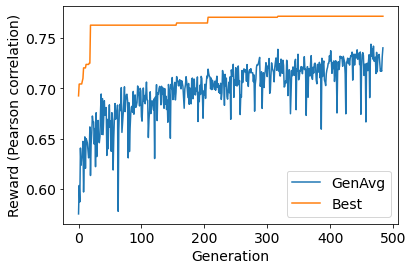

In [17]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
plt.savefig("reward_vs_time.png")

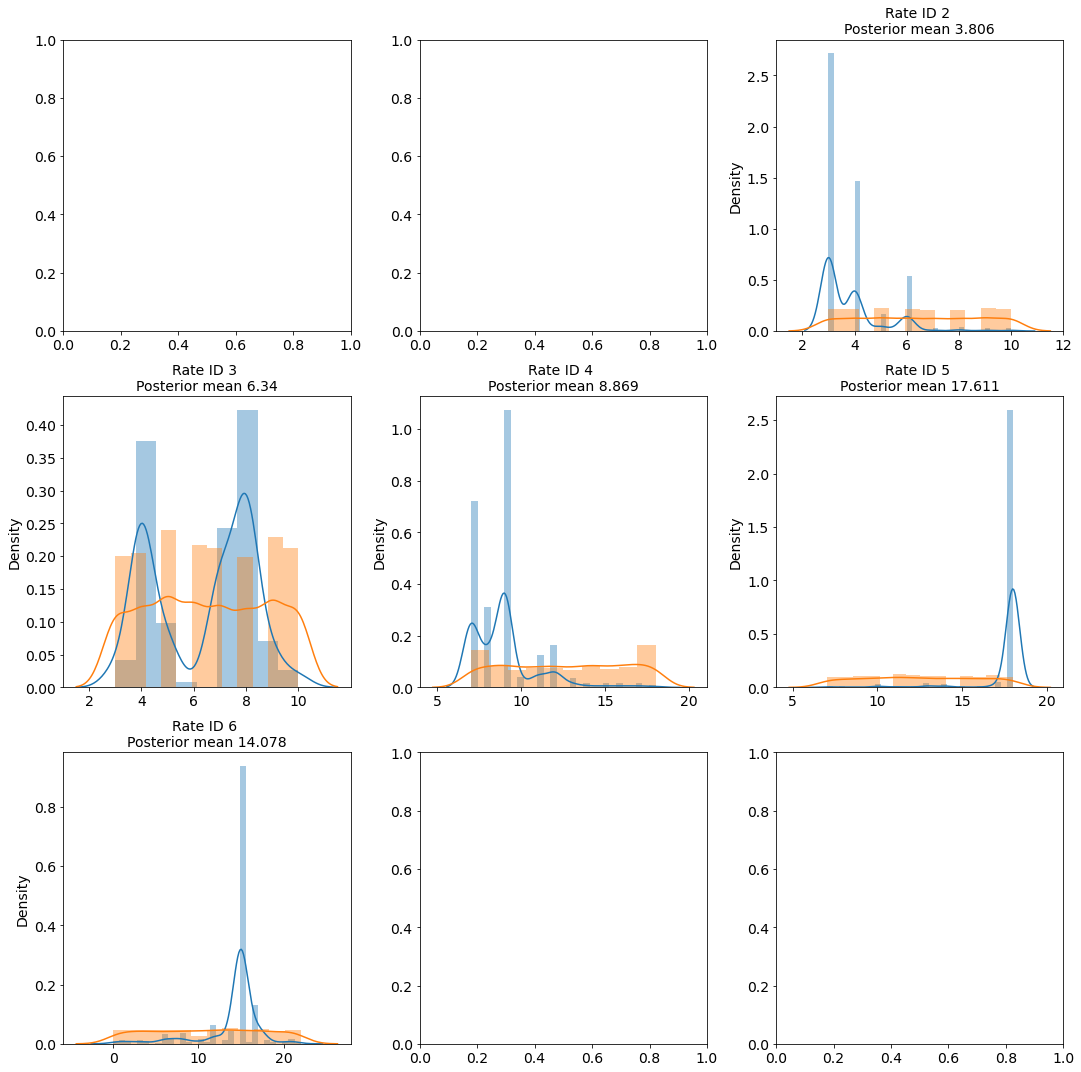

In [18]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)
fig.tight_layout()
fig.savefig("range_st.png")

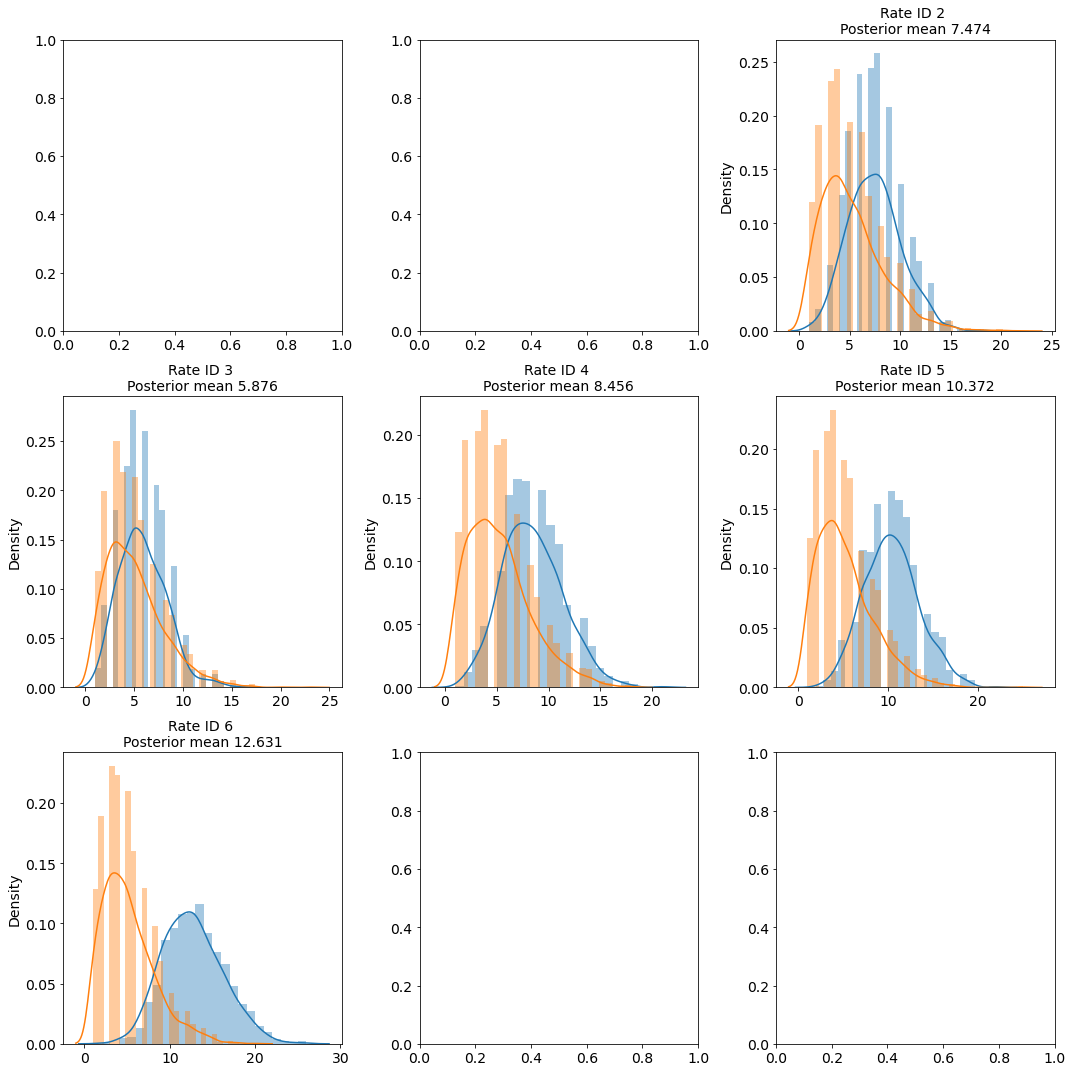

In [19]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20)    
fig.tight_layout()
fig.savefig("range_d.png")

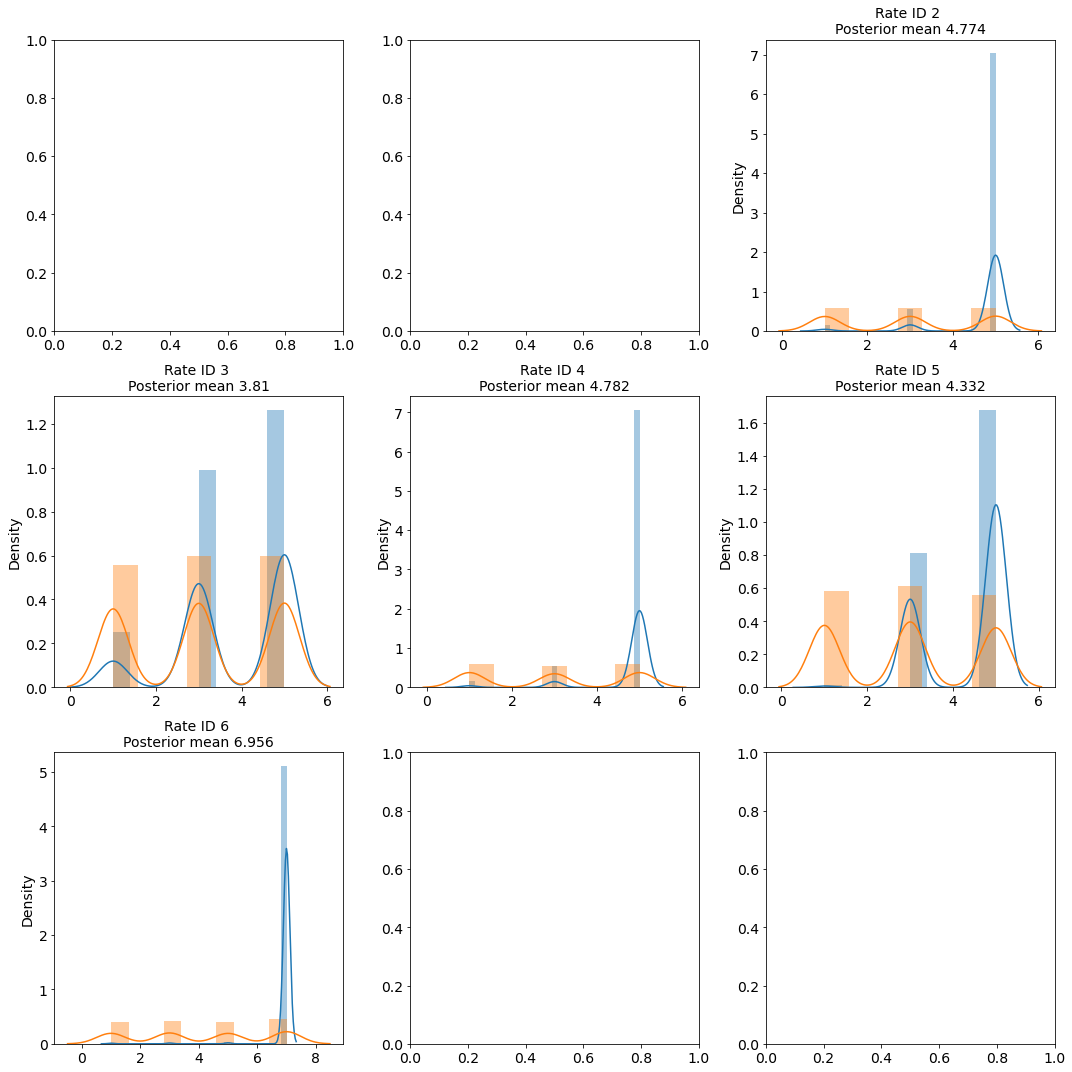

In [20]:
# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20)    
fig.tight_layout()